## Quality assurance when you have fully labelled data

In this example, our data contains a fully-populated ground-truth column called `cluster` that enables us to perform accuracy analysis of the final model

In [1]:
import pandas as pd 
import altair as alt
alt.renderers.enable("mimetype")

df = pd.read_csv("./data/fake_1000.csv")
df.head(2)

,unique_id,first_name,surname,dob,city,email,cluster
0,0,Robert,Alan,1971-06-24,NaN,robert255@smith.net,0
1,1,Robert,Allen,1971-05-24,NaN,roberta25@smith.net,0


In [2]:
from splink.duckdb.duckdb_linker import DuckDBLinker
from splink.duckdb import duckdb_comparison_library as cl

settings = {
    "link_type": "dedupe_only",
    "blocking_rules_to_generate_predictions": [
        "l.first_name = r.first_name",
        "l.surname = r.surname",
    ],
    "comparisons": [
        cl.levenshtein_at_thresholds("first_name", 2),
        cl.levenshtein_at_thresholds("surname", 2),
        cl.levenshtein_at_thresholds("dob"),
        cl.exact_match("city", term_frequency_adjustments=True),
        cl.levenshtein_at_thresholds("email"),
    ],
    "retain_matching_columns": True,
    "retain_intermediate_calculation_columns": True,
}

In [3]:
linker = DuckDBLinker(df, settings, set_up_basic_logging=False)
deterministic_rules = [
    "l.first_name = r.first_name and levenshtein(r.dob, l.dob) <= 1",
    "l.surname = r.surname and levenshtein(r.dob, l.dob) <= 1",
    "l.first_name = r.first_name and levenshtein(r.surname, l.surname) <= 2",
    "l.email = r.email"
]

linker.estimate_probability_two_random_records_match(deterministic_rules, recall=0.7)


In [4]:
linker.estimate_u_using_random_sampling(max_pairs=1e6)

In [5]:
session_dob = linker.estimate_parameters_using_expectation_maximisation("l.dob = r.dob")
session_email = linker.estimate_parameters_using_expectation_maximisation("l.email = r.email")

In [6]:
linker.truth_space_table_from_labels_column(
    "cluster", match_weight_round_to_nearest=0.1
).as_pandas_dataframe(limit=5)

,truth_threshold,row_count,P,N,TP,TN,FP,FN,P_rate,N_rate,TP_rate,TN_rate,FP_rate,FN_rate,precision,recall
0,-18.4,4353.0,2031.0,2322.0,2031.0,0.0,2322.0,0.0,0.0,0.533425,1.000000,0.0,1.0,0.000000,0.466575,1.000000
1,-17.2,4353.0,2031.0,2322.0,2029.0,0.0,2322.0,2.0,0.0,0.533425,0.999015,0.0,1.0,0.000985,0.466330,0.999015
2,-16.2,4353.0,2031.0,2322.0,2026.0,0.0,2322.0,5.0,0.0,0.533425,0.997538,0.0,1.0,0.002462,0.465961,0.997538
3,-15.4,4353.0,2031.0,2322.0,2024.0,0.0,2322.0,7.0,0.0,0.533425,0.996553,0.0,1.0,0.003447,0.465716,0.996553
4,-14.2,4353.0,2031.0,2322.0,2019.0,0.0,2322.0,12.0,0.0,0.533425,0.994092,0.0,1.0,0.005908,0.465100,0.994092


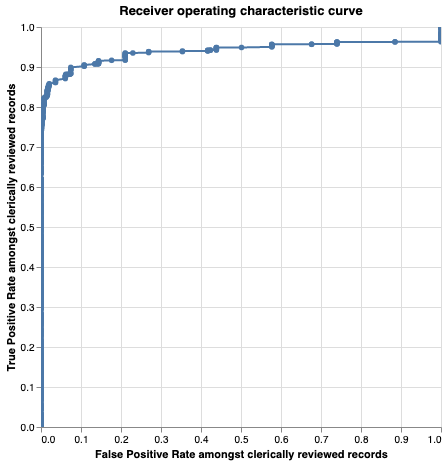

In [7]:
linker.roc_chart_from_labels_column("cluster")

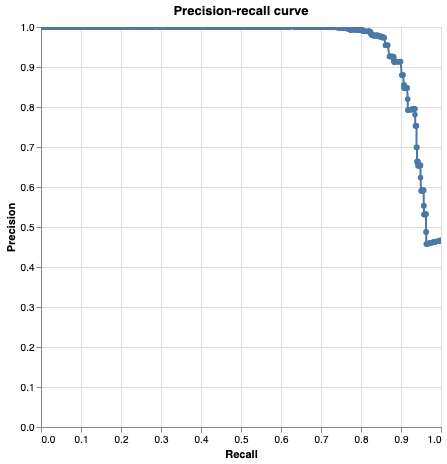

In [8]:
linker.precision_recall_chart_from_labels_column("cluster")

In [9]:
# Plot some false positives
linker.prediction_errors_from_labels_column(
    "cluster", include_false_negatives=True, include_false_positives=True
).as_pandas_dataframe(limit=5)

,clerical_match_score,found_by_blocking_rules,match_weight,match_probability,unique_id_l,unique_id_r,first_name_l,first_name_r,gamma_first_name,bf_first_name,...,tf_city_r,bf_city,bf_tf_adj_city,email_l,email_r,gamma_email,bf_email,cluster_l,cluster_r,match_key
0,0.0,True,0.205044,0.535472,486,619,Hannah,NaN,-1,1.000000,...,0.04920,10.852673,1.120874,NaN,od@holloway.info,-1,1.000000,122,157,1
1,1.0,True,-3.399559,0.086559,617,620,NaN,Olivia,-1,1.000000,...,0.04920,1.000000,1.000000,NaN,NaN,-1,1.000000,157,157,1
2,1.0,True,-3.399559,0.086559,618,620,NaN,Olivia,-1,1.000000,...,0.04920,1.000000,1.000000,od@holloway.info,NaN,-1,1.000000,157,157,1
3,1.0,True,-1.472365,0.264917,660,661,Charlie,Cahlrae,0,0.218912,...,0.00123,0.424936,1.000000,NaN,charlieh@sandoval-sanders.info,-1,1.000000,168,168,1
4,1.0,True,-2.268212,0.171902,505,508,NaN,NaN,-1,1.000000,...,0.00246,0.424936,1.000000,f.s@jharp.com,f.j@shrarp.com,0,0.126095,126,126,1


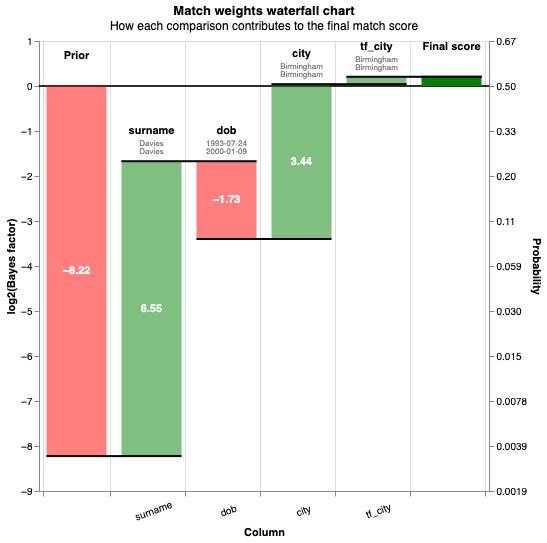

In [10]:
records = linker.prediction_errors_from_labels_column(
    "cluster", include_false_negatives=True, include_false_positives=True
).as_record_dict(limit=5)

linker.waterfall_chart(records)